# 入力ディレクトリ, ハイパパラメタ等定数定義

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import numpy as np
import random
import torch
import torch.optim as optim
import os


BATCH_SIZE = 4
TRAIN_VAL_DATADIR = "/content/drive/MyDrive/signate_lemon/train_pr"
TEST_DATADIR = "/content/drive/MyDrive/signate_lemon/test_pr"

OPTIMIZER = "adam"
if OPTIMIZER == "adam":
    optimizer = lambda p:optim.Adam(p, lr=5e-6, weight_decay=1e-12)
elif OPTIMIZER == "SGD":
    optimizer = lambda p:optim.SGD(p, lr=2e-4, momentum=0.9, nesterov=True, weight_decay=1e-12)

LINEAR_EVAL_EPOCHS = 1 #CNN部固定で訓練するepoch数
FINE_TUNE_EPOCHS = 70 #CNN部も訓練するepoch数
ROT_RANGE_DEG = 45 #0,90,180,270±(この角度)で回転augmentation
    
#Train/Valの分割ratio(0.0なら分けない)
TRAIN_VAL_SPLIT_RATIO = 0.0

IMG_ORIGINAL_SIZE = 400
SCALE_RANGE = (0.70, 1.1)
SCALE_TEST = 0.9
IMG_TEST_CROP = int(IMG_ORIGINAL_SIZE * SCALE_TEST)
SAVED_MODEL = None#"./result_XXX/Best.ckpt"
BEST_MODEL_NAME = "./Best.ckpt"
LAST_MODEL_NAME = "./Last.ckpt"

BASE_MODEL = "resnext101"
INPUT_HW = (384, 384)

# 乱数固定処理（テストしたところ, まだ完全に再現できていない模様）
SEED = None
if SEED is None:
    np.random.seed(None)
    SEED = np.random.randint(0, 2**31-1)

print(f"Using {SEED} as random seed")
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

def worker_init_fn(workerid):
    random.seed(SEED + worker_id)
    np.random.seed(SEED + worker_id)

Using 596292239 as random seed


# 入力画像の平均, 分散を計算
   * Imagenet転移学習前提なので（事前学習同様に）RGBの値を正規化して入れる想定で平均, 分散を計算
   * mean ,std を Noneにすると画像ピクセルを見て再計算する（遅い）
   * 時間がかかるため, 一度計算したら結果をmean, stdに入れておくと良い

In [3]:
import glob
import re
from PIL import Image, ImageFilter

mean = np.array([0.485, 0.456, 0.406])#None
std = np.array([0.229, 0.224, 0.225])#None

if mean is None or std is None:
    train_files = glob.glob(TRAIN_VAL_DATADIR + "./**", recursive=True)
    pat = re.compile(r'.*\.jp[e]?g', re.IGNORECASE)
    train_files = [t for t in train_files if re.match(pat, t)]

    means = []
    stds = []
    for t in train_files:
        im = np.array(Image.open(t)) / 255.0
        means.append(np.mean(im, axis=(0,1)))
        stds.append(np.std(im, axis=(0,1)))

    mean = np.mean(np.stack(means), axis=0)
    std = np.sqrt(np.mean(np.stack(stds) ** 2, axis=0))
print(mean)
print(std)

[0.485 0.456 0.406]
[0.229 0.224 0.225]


# 転移学習ベースの分類器を作成
   * Pytorchで扱えるものの中からResnet系をいろいろ
   * 最後が1000クラス分類になっているのを出力クラス数(2 or 4)に落とし込むだけ
   * VGG16→ResNext101でスコアは大幅に変わるが, 最初はVGG16で回りを固めた方がトライアル早い

In [6]:
import torch
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

MODEL_NAME = "resnetbasedclassifier"
class ResNetbased_classifier(nn.Module):
    def __init__(self, out_ch=4, basemodel="resnet50"):
        super().__init__()
        self.name = MODEL_NAME
        if basemodel == "vgg16":
            self.encoder = models.vgg16(pretrained=True)
        elif basemodel == "resnet50":
            self.encoder = models.resnet50(pretrained=True)
        elif basemodel == "resnet152":
            self.encoder = models.resnet152(pretrained=True)
        elif basemodel == "resnext101":
            self.encoder = models.resnext101_32x8d(pretrained=True)
        
        self.dense = nn.Linear(1000, out_ch)

        self.freeze_enc(True)
        self.param_dict = {
            "modelname": self.name,
            "out_ch": out_ch,
            "basemodel": basemodel
        }

    def forward(self, x):
        x = self.encoder(x)
        y = self.dense(x)
        return F.softmax(y,dim=1)
    
    def freeze_enc(self, freeze:bool):
        for param in list(self.encoder.parameters()):
            param.requres_grad = not freeze

    def get_param_dict(self):
        return self.param_dict
    
    @staticmethod
    def load_from_ckpt(ckpt_path):
        saved_dict = torch.load(ckpt_path)
        params = saved_dict["model_param_dict"]
        model_name = params.get("modelname")
        if model_name is None:
            model_name = params.pop("model")
        else:
            params.pop("modelname")
        if model_name != MODEL_NAME:
            assert False, f"{ckpt_path} is not suitable weight!(modelname={MODEL_NAME})"
        model = ResNetbased_classifier(**params)
        model.load_state_dict(saved_dict["model_state_dict"])
        return model, saved_dict

# Data Augmentationの設定と確認
   * 回転, 併進 ,スケール, 明るさ/コントラストなどの汎化性能上げるためAugmentation
   * Train/Valは最初は画像を分けていたが固まった以降は全部Trainに入れて（TRAIN_VAL_SPLIT_RATIO==0で）学習
        * 中央クロップの特殊な場合をValidationに使う, という考え
        * Val Loss < Train Lossの間は過学習の懸念少ないはず

['1', '0', '0', '0']


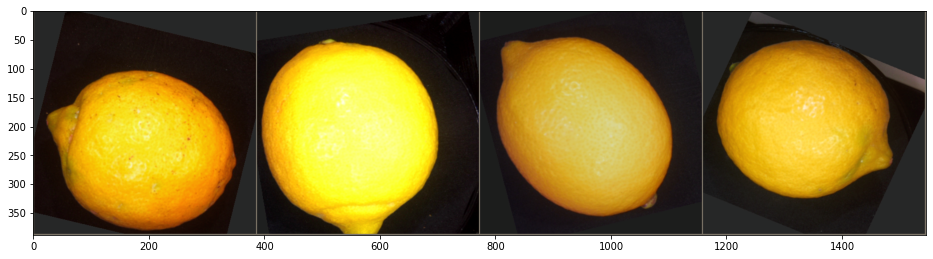

['0', '0', '0', '0']


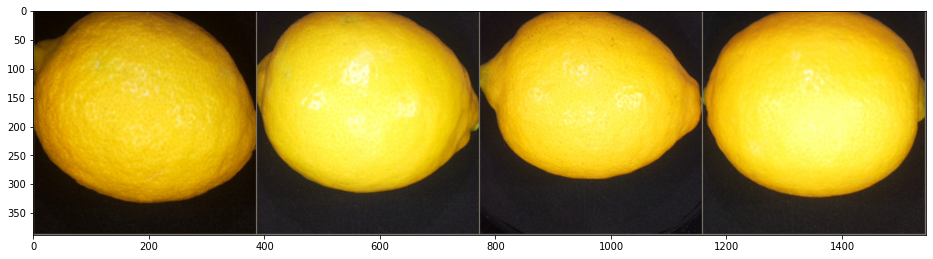

In [14]:
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF
import random
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
%matplotlib inline
    
class GaussianBlur(object):
    def __init__(self, blur_range):
        self.blur_range = blur_range
    def __call__(self, img):
        blur_val = np.random.uniform(*self.blur_range)
        return img.filter(ImageFilter.GaussianBlur(radius=blur_val))

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomChoice([ #回転汎化
            transforms.RandomRotation(
                (base_deg - ROT_RANGE_DEG,
                 base_deg + ROT_RANGE_DEG),
                resample=Image.BILINEAR,
                expand=True,
                fill=(35,35,35)) for base_deg in [0, 90, 180, 270]
        ]),
        transforms.RandomResizedCrop(INPUT_HW,scale=SCALE_RANGE,ratio=(0.9,1.1),interpolation=Image.BICUBIC), #位置汎化
        transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.05), #明るさ/色ずれ等汎化
        GaussianBlur((0.0,0.5)), #ピンボケ汎化
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val_test': transforms.Compose([ #中央切り出し
        transforms.CenterCrop(IMG_TEST_CROP),
        transforms.Resize(INPUT_HW, interpolation=Image.LANCZOS),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}
class DsetWithTransform(Dataset):
    def __init__(self, subset, transform=None):
        super().__init__()
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)


image_dataset = datasets.ImageFolder(TRAIN_VAL_DATADIR)

if TRAIN_VAL_SPLIT_RATIO > 0:
    val_samples = int(len(image_dataset) * TRAIN_VAL_SPLIT_RATIO)
    td, vd = torch.utils.data.random_split(image_dataset,[len(image_dataset)-val_samples,val_samples])
    train_dataset = DsetWithTransform(td, data_transforms["train"])
    val_dataset = DsetWithTransform(vd, data_transforms["val_test"])
else:
    train_dataset = datasets.ImageFolder(TRAIN_VAL_DATADIR, transform=data_transforms["train"])
    val_dataset = datasets.ImageFolder(TRAIN_VAL_DATADIR, transform=data_transforms["val_test"])
    
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    worker_init_fn=worker_init_fn)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    worker_init_fn=worker_init_fn)
class_names = image_dataset.classes

def torch_img_to_numpy(torch_tensor):
    nparr = torch_tensor.numpy().transpose((1, 2, 0))
    nparr = std * nparr + mean
    nparr = np.clip(nparr, 0, 1)
    return nparr

def imshow(inp, title=None):
    """Imshow for Tensor."""
    fig, ax = plt.subplots(figsize=(16,10))
    ax.imshow(torch_img_to_numpy(inp))
    if title is not None:
        ax.title(title)
    plt.show()

#Trainingデータを表示
inputs, classes = next(iter(train_loader))
out = torchvision.utils.make_grid(inputs)
title=[class_names[x] for x in classes]
print(title)
imshow(out)

#Validationデータを表示
inputs, classes = next(iter(val_loader))
out = torchvision.utils.make_grid(inputs)
title=[class_names[x] for x in classes]
print(title)
imshow(out)

# クラスバランス補正
   * AIが訓練時のサンプル出現確率を覚えてしまうのを補正するため, クラス重みを計算
   * 後でLoss計算時に設定して使用する

In [ ]:
import pandas as pd
dset = image_dataset
df = pd.DataFrame(dset.imgs, columns=["path","clsid"])
clsidcnt = [np.sum(df["clsid"] == dset.class_to_idx[cls]).astype(np.int) for cls in dset.classes]
print(clsidcnt)
eps = 1e-12 #0div対策
weight = 1 / (np.array(clsidcnt) + eps)
weight = weight / weight.mean()
print(weight)

[30, 57, 103, 100]
[1.88895056 0.9941845  0.55017977 0.56668517]


# AIインスタンス生成
   * 重みファイルがある場合にはそこから復帰、Noneなら新たに生成
   * 新たに生成した場合はPytorchのImageNet事前学習重みがダウンロードされる

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

if SAVED_MODEL is not None and os.path.exists(SAVED_MODEL):
    model, data = ResNetbased_classifier.load_from_ckpt(SAVED_MODEL)
    model = model.eval().to(device)
    losses = data["meta_dict"]["train_history"]
else:
    model = ResNetbased_classifier(out_ch=len(clsidcnt),basemodel=BASE_MODEL).to(device)
    losses = []

optimizer = optimizer(model.parameters())
crit = nn.CrossEntropyLoss(weight=torch.tensor(weight.astype(np.float32)).to(device))
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.9,verbose=True)

# Train/Validation処理定義
   * その他, 実行中の学習曲線確認や重み保存処理など

In [ ]:
from ipywidgets import FloatProgress
from IPython.display import display, clear_output
def train(model, dev, loader, optimizer, crit, freeze_cnn=False):
    losses = torch.empty(0,dtype=torch.float).to(dev)
    accs = torch.empty(0,dtype=torch.float).to(dev)
    if freeze_cnn:
        model.freeze_enc(False)
    else:
        model.train()
    for idx, (data,label) in enumerate(loader):
        x,t = data.to(dev, non_blocking=True), label.to(dev, non_blocking=True)
        y = model(x)
        loss = crit(y, t)
        acc = (torch.argmax(y,dim=1) == t).float()
        optimizer.zero_grad()
        loss.backward()
        accs = torch.cat((accs, acc),dim=0)
        losses = torch.cat((losses,loss.unsqueeze(0)),dim=0)
        optimizer.step()
    return torch.mean(losses).cpu(), torch.mean(accs).cpu()

def val(model, dev, loader, crit):
    losses = torch.empty(0,dtype=torch.float).to(dev)
    accs = torch.empty(0,dtype=torch.float).to(dev)
    model.eval()
    with torch.no_grad():
        for idx, (data,label) in enumerate(loader):
            x,t = data.to(dev, non_blocking=True), label.to(dev, non_blocking=True)
            y = model(x)
            loss = crit(y, t)
            acc = (torch.argmax(y,dim=1) == t).float()
            accs = torch.cat((accs, acc),dim=0)
            losses = torch.cat((losses,loss.unsqueeze(0)),dim=0)
    return torch.mean(losses).cpu(), torch.mean(accs).cpu()
    
def plot_loss_acc(ax, datas, keys,title,yrange=None):
    ax.cla()
    for key in keys:
        vals = [d[key] for d in datas]
        ax.plot(np.arange(len(datas)),vals, label=key)
        [ax.text(x,y,f"{y:.2f}") for (x,y) in zip(np.arange(len(datas)),vals)
         if x==len(datas)-1 or (x % np.ceil(len(datas) / 10).astype(np.int)==0)]
    ax.legend(loc='lower left', borderaxespad=0)
    ax.set_xlim(0,10) if len(datas) < 10 else ax.set_xlim(0,len(datas))
    if yrange is not None:
        ax.set_ylim(yrange)
    ax.set_title(title)
    
def save_training(output_path, model, optim=None, meta_dict=None):
    if not os.path.exists(os.path.dirname(output_path)):
        os.makedirs(os.path.dirname(output_path))
    if isinstance(model, torch.nn.DataParallel):
        model = model.module
    save_dict = {
        "model_state_dict":model.state_dict(),
        "model_param_dict":model.get_param_dict(),
        "optim_state_dict":optim.state_dict() if optim is not None else None,
        "meta_dict": meta_dict
    }
    torch.save(save_dict, output_path)

# 訓練実施

Wall time: 1h 1min 26s


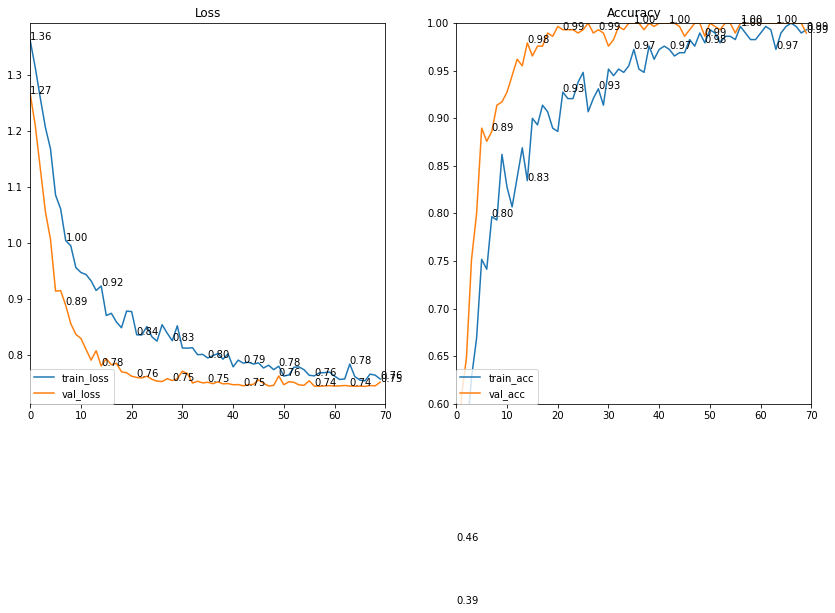

In [ ]:
%%time

plt.ion()
fig, ax = plt.subplots(figsize=(14,7),ncols=2)
best_loss = 1e5
cur_epoch = len(losses) + 1
if SAVED_MODEL is None:
    for step in range(cur_epoch, LINEAR_EVAL_EPOCHS):
        train_loss,train_acc = train(model, device, train_loader, optimizer, crit, freeze_cnn=True)
        val_loss,val_acc = val(model, device, val_loader, crit)
        losses.append({"train_loss":train_loss, "val_loss":val_loss, "train_acc":train_acc, "val_acc":val_acc})
        scheduler.step(val_loss)

        clear_output(wait = True)
        plot_loss_acc(ax[0], losses, ["train_loss", "val_loss"], "Loss")
        plot_loss_acc(ax[1], losses, ["train_acc", "val_acc"], "Accuracy", yrange=(0.3,1.0))
        display(fig)

    cur_epoch = len(losses) + 1
    for step in range(cur_epoch, FINE_TUNE_EPOCHS + LINEAR_EVAL_EPOCHS):
        train_loss,train_acc = train(model, device, train_loader, optimizer, crit, freeze_cnn=False)
        val_loss,val_acc = val(model, device, val_loader, crit)
        losses.append({"train_loss":train_loss, "val_loss":val_loss, "train_acc":train_acc, "val_acc":val_acc})
        scheduler.step(val_loss)
        if val_loss < best_loss:
            best_loss = val_loss
            save_training(BEST_MODEL_NAME, model, meta_dict ={
                "train_history": losses
            })

        clear_output(wait = True)
        plot_loss_acc(ax[0], losses, ["train_loss", "val_loss"], "Loss")
        plot_loss_acc(ax[1], losses, ["train_acc", "val_acc"], "Accuracy", yrange=(0.6,1.0))
        display(fig)

clear_output(wait = True)
plot_loss_acc(ax[0], losses, ["train_loss", "val_loss"], "Loss")
plot_loss_acc(ax[1], losses, ["train_acc", "val_acc"], "Accuracy", yrange=(0.6,1.0))
plt.ioff()

# 結果出力用モデルの読み出し
   * 新規モデル生成して訓練した場合は, 訓練中もっともVal Lossが低かった時点の重みを読み出す

In [ ]:
if SAVED_MODEL is None:
    save_training(LAST_MODEL_NAME, model, meta_dict ={
        "train_history": losses
    })

    load_model, _ = ResNetbased_classifier.load_from_ckpt(BEST_MODEL_NAME)
    if device == "cuda":
        load_model.eval().to(device)
        scripted_model = torch.jit.script(load_model)
        del(model)
        torch.cuda.empty_cache()
        model = load_model

# 推論を実施, 4クラス→2クラス化
   * 4クラス分類したものを元に「Regularかそうでないか」の2クラスに落とす
      * 2クラスに落とす際には「Regularが1番確率が高い」ではなく「Regularが0.5以下」で判断する
      * Regular0.4, Potato0.3, Horn0.3のような場合はRegularでない可能性が高いため

In [ ]:
%%time

test_dataset = datasets.ImageFolder(TEST_DATADIR,data_transforms["val_test"])
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)
labels = np.empty(0)
probs = torch.empty((0,len(clsidcnt))).to(device)
with torch.no_grad():
    for idx, (data,label) in enumerate(testloader):
        x = data.to(device)
        y = model(x)
        labels = np.concatenate((labels, label))
        probs = torch.cat((probs, y), axis=0)

probs = probs.cpu().numpy()
preds = np.argmax(probs, axis=1)
#preds_tf = (probs[:,class_names.index("regular")] > 0.5).astype(np.int)

Wall time: 5.84 s


# 結果を投稿用形式にして出力

In [ ]:
import pandas as pd
import datetime
filenames = [os.path.basename(p[0]) for p in test_dataset.imgs]
pred_ft = np.logical_not(preds).astype(np.int)
df = pd.DataFrame(zip(filenames, pred_ft), columns=["filename", "class"])
df = df.sort_values("filename")
display(df)
df.to_csv(f"submit_{datetime.datetime.now().strftime('%Y%m%d%H%M%S')}_{SEED}.csv", index=False, header=False)

,filename,regular0_defect1
0,000.jpeg,1
1,001.jpeg,0
2,002.jpeg,0
3,003.jpeg,0
4,004.jpeg,1
...,...,...
208,208.jpeg,1
209,209.jpeg,0
210,210.jpeg,0
211,211.jpeg,1
